In [17]:
from __future__ import division
import os
import sys
import time
import glob
import logging
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.utils
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

from tensorboardX import SummaryWriter

from torchvision.utils import save_image

import numpy as np
import matplotlib

# Force matplotlib to not use any Xwindows backend.
matplotlib.use("Agg")
from matplotlib import pyplot as plt
from PIL import Image

from config_eval import config
from datasets import ImageDataset, PairedImageDataset

from utils.init_func import init_weight

from utils.darts_utils import (
    create_exp_dir,
    save,
    plot_op,
    plot_path_width,
    objective_acc_lat,
)
from model_eval import NAS_GAN_Eval

from util_gan.cyclegan import Generator
# from util_gan.fid_score import compute_fid
from util_gan.lr import LambdaLR

from quantize import QConv2d, QConvTranspose2d, QuantMeasure
from thop import profile
from thop.count_hooks import count_convNd

import wandb
from datetime import datetime
from matplotlib import pyplot as plt
from torchinfo import summary


def count_custom(m, x, y):
    m.total_ops += 0


custom_ops = {
    QConv2d: count_convNd,
    QConvTranspose2d: count_convNd,
    QuantMeasure: count_custom,
    nn.InstanceNorm2d: count_custom,
}

In [94]:
# load env config
config.USE_MAESTRO = os.environ.get("USE_MAESTRO", "0") == "1"
config.TEST_RUN = True
config.stage = "eval"
config.save = "ckpt/eval"
try:
    config.seed = int(os.environ.get("RNG_SEED", "12345"))
except:
    pass
# wandb run
run = wandb.init(
    project="AGD_Maestro",
    name=f"{config.dataset}-{config.stage}-{'with' if config.USE_MAESTRO is True else 'without'}_maestro",
    tags=[config.dataset, "AGD", config.stage]
    + (["maestro"] if config.USE_MAESTRO is True else []),
    entity="rcai",
    group=os.environ.get("WANDB_GROUP", None) or f"AGD_Maestro ({datetime.now()})",
    job_type=f"Stage {config.stage}",
    reinit=True,
    sync_tensorboard=True,
    save_code=True,
    mode="disabled",
    config=config,
)
# Create logger
logger = SummaryWriter(config.save)
# preparation ################
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
seed = config.seed
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

state = torch.load(os.path.join(config.load_path, "arch.pt"))
# Model #######################################
model = NAS_GAN_Eval(
    state["alpha"],
    state["beta"],
    state["ratio"],
    state["beta_sh"],
    state["ratio_sh"],
    layers=config.layers,
    width_mult_list=config.width_mult_list,
    width_mult_list_sh=config.width_mult_list_sh,
    quantize=config.quantize,
)

if not config.real_measurement:
    flops, params = profile(
        model, inputs=(torch.randn(1, 3, 256, 256),), custom_ops=custom_ops
    )
    flops = model.forward_flops(size=(3, 256, 256))
    logger.add_scalars(
        "",
        {
            "params": params,
            "FLOPs": flops,
        },
    )
    logger.add_text(
        "model_summary", str(summary(model, input_size=(1, 3, 256, 256)))
    )
    print("params = %fMB, FLOPs = %fGB" % (params / 1e6, flops / 1e9))

model = torch.nn.DataParallel(model).cuda()
# model = model.cuda()

if config.ckpt:
    state_dict = torch.load(config.ckpt)
    model.load_state_dict(state_dict, strict=False)

transforms_ = [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]
test_loader = DataLoader(
    ImageDataset(config.dataset_path, transforms_=transforms_, mode="test"),
    batch_size=1,
    shuffle=False,
    num_workers=config.num_workers,
)

# with torch.no_grad():
#     valid_fid = infer(model, test_loader, logger, run)
#     logger.add_scalar("fid", valid_fid)
#     print("Eval Fid:", valid_fid)
# logger.close()


def infer(model, test_loader, logger, run):
    model.eval()

    if not config.real_measurement:
        outdir = "output/eval"
        if not os.path.exists(outdir):
            os.makedirs(outdir)

    # store image comparissions in table
    comp_table = wandb.Table(columns=["Real Image", "Generated Image"])
    for i, batch in enumerate(test_loader):
        # Set model input
        real_A = Variable(batch["A"]).cuda()
        fake_B = 0.5 * (model(real_A).data + 1.0)

        if not config.real_measurement:
            temp_path = os.path.join(outdir, "%04d.png" % (i + 1))
            save_image(fake_B, temp_path)
            comp_table.add_data(wandb.Image(real_A), wandb.Image(temp_path))
    logger.add_graph(model, real_A)
    run.log(
        {
            "Eval._Images": comp_table,
        }
    )
    if not config.real_measurement:
    #         fid = compute_fid(outdir, config.dataset_path + "/test/B")
        fid = 0
        try:
            os.rename(outdir, outdir + "_%.3f" % (fid))
        except:
            pass
    else:
        fid = 0

    return fid
# input("Waiting for user input...")

wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init
wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init
wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Register FLOP counter for module QConv2d(3, 24, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
Register FLOP counter for module InstanceNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
Register FLOP counter for module ReLU(inplace=True)
Register FLOP counter for module QConv2d(24, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Register FLOP counter for module InstanceNorm2d(40, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
Register FLOP counter for module ReLU(inplace=True)
Register FLOP counter for module QConv2d(40, 88, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Register FLOP counter for module InstanceNorm2d(88, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
Register FLOP counter for module ReLU(inplace=True)
Register FLOP counter for module ReLU(inplace=True)
Register FLOP counter for module QConv2d(88, 88, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [95]:
model

DataParallel(
  (module): NAS_GAN_Eval(
    (stem): ModuleList(
      (0): SingleOp(
        (_op): ConvNorm(
          (conv): QConv2d(3, 24, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
          (bn): InstanceNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (relu): ReLU(inplace=True)
        )
      )
      (1): SingleOp(
        (_op): ConvNorm(
          (conv): QConv2d(24, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): InstanceNorm2d(40, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (relu): ReLU(inplace=True)
        )
      )
      (2): SingleOp(
        (_op): ConvNorm(
          (conv): QConv2d(40, 88, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): InstanceNorm2d(88, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (relu): ReLU(inplace=True)
        )
      )
    )
    (cells): ModuleList(
      (0)

In [96]:
def state_dict_repr(d):
    it = d.items()
    return dict((
        (k, list(v.shape)) for k,v in it
    ))

state_dict_repr(state_dict)

{'module.vgg.module.vgg.to_relu_1_2.0.weight': [64, 3, 3, 3],
 'module.vgg.module.vgg.to_relu_1_2.0.bias': [64],
 'module.vgg.module.vgg.to_relu_1_2.2.weight': [64, 64, 3, 3],
 'module.vgg.module.vgg.to_relu_1_2.2.bias': [64],
 'module.vgg.module.vgg.to_relu_2_2.5.weight': [128, 64, 3, 3],
 'module.vgg.module.vgg.to_relu_2_2.5.bias': [128],
 'module.vgg.module.vgg.to_relu_2_2.7.weight': [128, 128, 3, 3],
 'module.vgg.module.vgg.to_relu_2_2.7.bias': [128],
 'module.vgg.module.vgg.to_relu_3_3.10.weight': [256, 128, 3, 3],
 'module.vgg.module.vgg.to_relu_3_3.10.bias': [256],
 'module.vgg.module.vgg.to_relu_3_3.12.weight': [256, 256, 3, 3],
 'module.vgg.module.vgg.to_relu_3_3.12.bias': [256],
 'module.vgg.module.vgg.to_relu_3_3.14.weight': [256, 256, 3, 3],
 'module.vgg.module.vgg.to_relu_3_3.14.bias': [256],
 'module.vgg.module.vgg.to_relu_4_3.17.weight': [512, 256, 3, 3],
 'module.vgg.module.vgg.to_relu_4_3.17.bias': [512],
 'module.vgg.module.vgg.to_relu_4_3.19.weight': [512, 512, 3, 3]

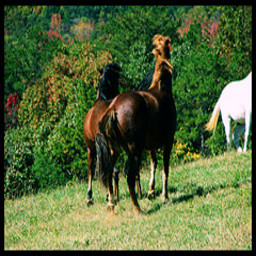

In [97]:
sample = next(iter(test_loader))
x, y = sample.values()

from torchvision.transforms import ToPILImage
def show(x):
    return ToPILImage()(torch.squeeze(0.5*(x+1)))

show(x)

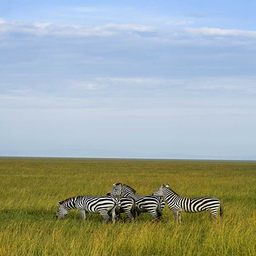

In [98]:
show(y)

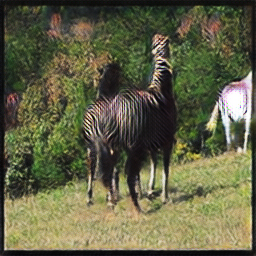

In [100]:
# model.load_state_dict(state_dict)
show(model(x.cuda()).cpu())

In [92]:
a = state_dict_repr(state_dict)
b = state_dict_repr(model.state_dict())

# {
#     k: " | ".join([str(v), str(b[k])]) for k,v in b.items() if k in b
# }

In [102]:
summary(model, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                             Output Shape              Param #
DataParallel                                       --                        --
├─NAS_GAN_Eval: 1                                  --                        --
│    └─ModuleList: 2-1                             --                        --
│    └─ModuleList: 2-2                             --                        --
│    └─ModuleList: 2-3                             --                        --
├─NAS_GAN_Eval: 1-1                                [1, 3, 256, 256]          --
├─NAS_GAN_Eval: 1                                  --                        --
│    └─ModuleList: 2-1                             --                        --
│    │    └─SingleOp: 3-1                          [1, 24, 256, 256]         3,528
│    │    └─SingleOp: 3-2                          [1, 40, 128, 128]         8,640
│    │    └─SingleOp: 3-3                          [1, 88, 64, 64]           31,680
│    └─ModuleList: 2-2   

In [90]:
a

{'module.vgg.module.vgg.to_relu_1_2.0.weight': [64, 3, 3, 3],
 'module.vgg.module.vgg.to_relu_1_2.0.bias': [64],
 'module.vgg.module.vgg.to_relu_1_2.2.weight': [64, 64, 3, 3],
 'module.vgg.module.vgg.to_relu_1_2.2.bias': [64],
 'module.vgg.module.vgg.to_relu_2_2.5.weight': [128, 64, 3, 3],
 'module.vgg.module.vgg.to_relu_2_2.5.bias': [128],
 'module.vgg.module.vgg.to_relu_2_2.7.weight': [128, 128, 3, 3],
 'module.vgg.module.vgg.to_relu_2_2.7.bias': [128],
 'module.vgg.module.vgg.to_relu_3_3.10.weight': [256, 128, 3, 3],
 'module.vgg.module.vgg.to_relu_3_3.10.bias': [256],
 'module.vgg.module.vgg.to_relu_3_3.12.weight': [256, 256, 3, 3],
 'module.vgg.module.vgg.to_relu_3_3.12.bias': [256],
 'module.vgg.module.vgg.to_relu_3_3.14.weight': [256, 256, 3, 3],
 'module.vgg.module.vgg.to_relu_3_3.14.bias': [256],
 'module.vgg.module.vgg.to_relu_4_3.17.weight': [512, 256, 3, 3],
 'module.vgg.module.vgg.to_relu_4_3.17.bias': [512],
 'module.vgg.module.vgg.to_relu_4_3.19.weight': [512, 512, 3, 3]

In [91]:
b

{'stem.0._op.conv.weight': [24, 3, 7, 7],
 'stem.1._op.conv.weight': [40, 24, 3, 3],
 'stem.2._op.conv.weight': [88, 40, 3, 3],
 'cells.0._op.conv1.weight': [88, 88, 3, 3],
 'cells.0._op.conv2.weight': [88, 88, 3, 3],
 'cells.1._op.conv1.weight': [88, 88, 3, 3],
 'cells.1._op.conv2.weight': [88, 88, 3, 3],
 'cells.2._op.conv1.weight': [88, 88, 3, 3],
 'cells.2._op.conv2.weight': [88, 88, 3, 3],
 'cells.3._op.conv1.weight': [88, 88, 3, 3],
 'cells.3._op.conv2.weight': [88, 88, 3, 3],
 'cells.4._op.conv1.weight': [352, 88, 1, 1],
 'cells.4._op.conv2.weight': [352, 1, 3, 3],
 'cells.4._op.conv3.weight': [88, 352, 1, 1],
 'cells.5._op.conv1.weight': [352, 88, 1, 1],
 'cells.5._op.conv2.weight': [352, 1, 3, 3],
 'cells.5._op.conv3.weight': [88, 352, 1, 1],
 'cells.6._op.conv1.weight': [88, 88, 3, 3],
 'cells.6._op.conv2.weight': [88, 88, 3, 3],
 'cells.7._op.conv.weight': [88, 88, 1, 1],
 'cells.8._op.conv.weight': [88, 88, 1, 1],
 'header.0._op.conv.weight': [88, 128, 3, 3],
 'header.1._op